<a href="https://colab.research.google.com/github/Abdulhady-Feteiha/End-of-document-splitter/blob/main/Combined_LSTM_with_CNN_EOD_(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2 as cv
import pandas as pd
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Input, Dense,concatenate, Dropout,LeakyReLU,Conv2D,MaxPooling2D,Dropout,Flatten,TimeDistributed,LSTM
from keras.optimizers import Adam
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import normalize
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint

from math import floor
from PIL import Image, ImageFile,ImageOps
from urllib.request import urlopen

import keras
from keras import backend as K
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input



Using TensorFlow backend.


In [ ]:
import tensorflow as tf
from keras import backend as K

def f1(y_true, y_pred):
    p=tf.dtypes.cast((K.argmax(y_pred,axis=1)),tf.float32)
    t=tf.dtypes.cast((K.argmax(y_true,axis=1)),tf.float32)
    def recall(y_true, y_pred):
        true_positives = K.sum(p*t)
        possible_positives = K.sum(t)
        recall = true_positives / (possible_positives+ K.epsilon() )
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(p*t)
        predicted_positives = K.sum(p)
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def chopper(Dataset,window_size):
  chop=list(range(window_size))
  chDataset=np.delete(Dataset,chop,0)
  return chDataset

In [ ]:
def sequencer(Dataset,window_size):
  sample=0
  sDataset=[]
  SDataset=[]
  while sample<len(Dataset)-window_size:
    for time_step in range(window_size):
      
      sDataset.append(Dataset[sample+time_step,:,:])
    
    sample+=1
    SDataset.append(sDataset)
    sDataset=[]
    
  return SDataset

In [ ]:
data_path = 'Train_Dataset.txt'
Train_shape = (38775, 100, 100)

Train_DS = np.loadtxt(data_path)
print (Train_DS.shape)
Train_DS = Train_DS.reshape(Train_shape)
print (Train_DS.shape)


(3877500, 100)
(38775, 100, 100)


In [ ]:
data_path = 'Test_Dataset.txt'
Test_shape = (9395, 100, 100)

Test_DS = np.loadtxt(data_path)
print (Test_DS.shape)
Test_DS = Test_DS.reshape(Test_shape)
print (Test_DS.shape)

(939500, 100)
(9395, 100, 100)


# LSTM Model


In [ ]:
window_size=3

In [ ]:
# Tr_chDataset=chopper(Train_DS,window_size)
# Tr_chDataset.shape


In [ ]:
# Ts_chDataset=chopper(Test_DS,window_size)
# Ts_chDataset.shape


In [ ]:
Tr_Dataset=sequencer(Train_DS,window_size)
Tr_DatasetLSTM=np.asarray(Tr_Dataset)
Tr_DatasetLSTM.shape
del Tr_Dataset

In [ ]:
Ts_Dataset=sequencer(Test_DS,window_size)
Ts_DatasetLSTM=np.asarray(Ts_Dataset)
Ts_DatasetLSTM.shape
del Ts_Dataset

In [ ]:
# window_size=3
InLSTM = Input(shape=(3,100,100,1))
ConvLSTM1 = TimeDistributed(Conv2D(32, kernel_size=(7,7),activation='relu'),name="Conv2d_1")(InLSTM)
PoolLSTM1 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)),name="MaxPooling2D_1")(ConvLSTM1)
DropoutLSTM1 = TimeDistributed(Dropout(0.25),name="Dropout_1")(PoolLSTM1)
ConvLSTM2 = TimeDistributed(Conv2D(32, kernel_size=(5,5),activation='relu'),name="Conv2d_2")(DropoutLSTM1)
PoolLSTM2 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)),name="MaxPooling2D_2")(ConvLSTM2)
DropoutLSTM2 = TimeDistributed(Dropout(0.5),name="Dropout_2")(PoolLSTM2)
FlatLSTM = TimeDistributed(Flatten(),name="Flatten_1")(DropoutLSTM2)
Lstm = LSTM(32, activation='relu',dropout=0.5)(FlatLSTM)
OutLSTM = Dense(2,activation='softmax') (Lstm)




# CNN Model

In [ ]:
Tr_DatasetCNN = chopper(Train_DS,window_size)
Tr_DatasetCNN.shape
# del Train_DS

(38772, 100, 100)

In [ ]:
Ts_DatasetCNN = chopper(Test_DS,window_size)
Ts_DatasetCNN.shape
# del Test_DS

(9392, 100, 100)

In [ ]:

InCNN = Input(shape=(100,100,1))
Conv1 = Conv2D(32, kernel_size=(11,11),activation='relu')(InCNN)
Pool1=MaxPooling2D(pool_size=(2, 2))(Conv1)
Conv2 = Conv2D(64, (5, 5), activation='relu')(Conv1)
Pool2 = MaxPooling2D(pool_size=(2, 2))(Conv2)
Drop = Dropout(0.5)(Pool2)
Flat = Flatten()(Drop)
Dense1 = Dense(128, activation='relu')(Flat)
DenseDrop = Dropout(0.5)(Dense1)
OutCNN = Dense(2, activation='softmax')(DenseDrop)

# Main Model

In [ ]:
# labels=np.zeros((len(Tr_Dataset),1))

labels=np.zeros((38772,1))

df = pd.read_csv('9091.csv') 

EOD=np.asarray(df['Page#'],dtype=int)
EOD=EOD-1
for e in EOD:
  if e >window_size-1:
    labels[EOD-window_size]=1
Train_labels_cat = to_categorical(labels,2)

del labels
del df
del EOD

In [ ]:
# labels=np.zeros((len(Ts_Dataset),1))
labels=np.zeros((9392,1))

df = pd.read_csv('2000.csv') 

EOD=np.asarray(df['Page#'],dtype=int)
EOD=EOD-1
for e in EOD:
  if e >window_size-1:
    labels[EOD-window_size]=1
Test_labels_cat = to_categorical(labels,2)

print(EOD)

del labels
del df
del EOD

[   5   10   14 ... 9386 9389 9394]


In [ ]:
len(Train_labels_cat)

38772

In [ ]:
len(Test_labels_cat)

9392

In [ ]:

X_trainCNN, X_valiCNN,X_trainLSTM, X_valiLSTM, y_train, y_vali = train_test_split(Tr_DatasetCNN,Tr_DatasetLSTM, Train_labels_cat,shuffle=True)


X_trainCNN=np.reshape(X_trainCNN,(X_trainCNN.shape[0],X_trainCNN.shape[1],X_trainCNN.shape[2],1))
X_valiCNN=np.reshape(X_valiCNN,(X_valiCNN.shape[0],X_valiCNN.shape[1],X_valiCNN.shape[2],1))
X_testCNN=np.reshape(Ts_DatasetCNN,(Ts_DatasetCNN.shape[0],Ts_DatasetCNN.shape[1],Ts_DatasetCNN.shape[2],1))


X_trainLSTM=np.reshape(X_trainLSTM,(X_trainLSTM.shape[0],X_trainLSTM.shape[1],X_trainLSTM.shape[2],X_trainLSTM.shape[3],1))
X_valiLSTM=np.reshape(X_valiLSTM,(X_valiLSTM.shape[0],X_valiLSTM.shape[1],X_valiLSTM.shape[2],X_valiLSTM.shape[3],1))
X_testLSTM=np.reshape(Ts_DatasetLSTM,(Ts_DatasetLSTM.shape[0],Ts_DatasetLSTM.shape[1],Ts_DatasetLSTM.shape[2],Ts_DatasetLSTM.shape[3],1))


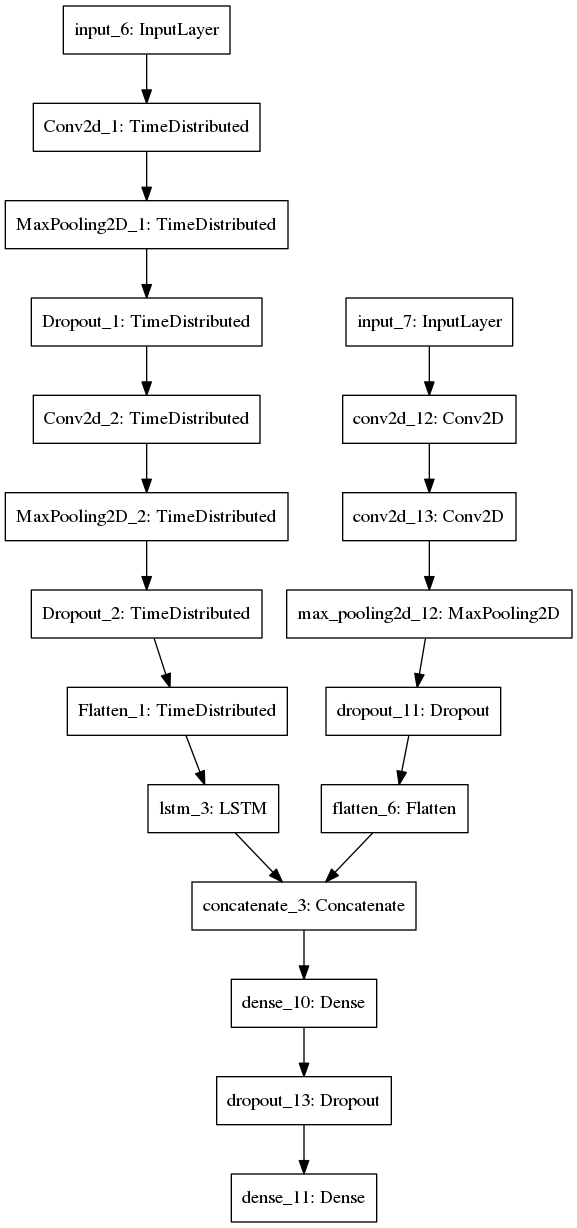

In [ ]:
LstmCnn = concatenate([Lstm, Flat])
densef = Dense(32,activation="relu")(LstmCnn)
dropf = Dropout(0.5)(densef)
OutMainModel = Dense(2,activation="softmax")(dropf)
MainModel = Model(inputs=[InLSTM,InCNN], outputs=OutMainModel)
MainModel.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',f1])
from tensorflow.keras.utils import plot_model
plot_model(MainModel, to_file='model.png')

In [ ]:
cp= ModelCheckpoint('model-{epoch:03d}-{f1:03f}-{val_f1:03f}.h5', verbose=1, monitor='val_f1',save_best_only=True, mode='max')  
es=EarlyStopping(monitor='val_f1', min_delta=0.01, patience=10, verbose=0, mode='max', baseline=None, restore_best_weights=False)


In [ ]:
run=MainModel.fit([X_trainLSTM,X_trainCNN],y_train,batch_size=32,epochs=50,verbose=1,shuffle=True,validation_data=([X_valiLSTM,X_valiCNN],y_vali),callbacks=[es,cp])
#run=MainModel.fit([X_trainLSTM,X_trainCNN],y_train,batch_size=32,epochs=10,verbose=1,shuffle=True,validation_data=([X_testLSTM,X_testCNN],y_test))

#try batch size [8,128]

Train on 29078 samples, validate on 9693 samples
Epoch 1/50
29078/29078 [==============================] - 51s 2ms/step - loss: 0.2797 - acc: 0.8995 - f1: 0.7177 - val_loss: 0.1657 - val_acc: 0.9326 - val_f1: 0.8469

Epoch 00001: val_f1 improved from -inf to 0.84686, saving model to model-001-0.717684-0.846855.h5
Epoch 2/50
29078/29078 [==============================] - 42s 1ms/step - loss: 0.1789 - acc: 0.9365 - f1: 0.8500 - val_loss: 0.1317 - val_acc: 0.9493 - val_f1: 0.8848

Epoch 00002: val_f1 improved from 0.84686 to 0.88480, saving model to model-002-0.850019-0.884802.h5
Epoch 3/50
29078/29078 [==============================] - 42s 1ms/step - loss: 0.1399 - acc: 0.9515 - f1: 0.8866 - val_loss: 0.1155 - val_acc: 0.9563 - val_f1: 0.9035

Epoch 00003: val_f1 improved from 0.88480 to 0.90347, saving model to model-003-0.886577-0.903466.h5
Epoch 4/50
29078/29078 [==============================] - 42s 1ms/step - loss: 0.1197 - acc: 0.9568 - f1: 0.8994 - val_loss: 0.1116 - val_acc: 0.95

In [ ]:
MainModel.load_weights("model-012-0.955056-0.922401.h5")
print("Validation")
MainModel.evaluate([X_valiLSTM,X_valiCNN],y_vali)

Validation
9693/9693 [==============================] - 5s 566us/step


[0.15806542750780841, 0.9645105004310608, 0.9224014282226562]

In [ ]:
print("Testing")
MainModel.evaluate([X_testLSTM,X_testCNN],Test_labels_cat)

Testing
9391/9391 [==============================] - 5s 570us/step


[0.15904076308706722, 0.963262677192688, 0.9022989869117737]

In [ ]:
print("Validation")
y_pred1 = MainModel.predict([X_valiLSTM,X_valiCNN])
y_pred = np.argmax(y_pred1, axis=1)
y_pred=to_categorical(y_pred)
print("precision[NO, YES]: ",precision_score(y_vali, y_pred , average=None))
print("recall[NO, YES]: ", recall_score(y_vali, y_pred , average=None))
print("f1[NO, YES]: ", f1_score(y_vali, y_pred , average=None))

Validation
precision[NO, YES]:  [0.97438317 0.93233743]
recall[NO, YES]:  [0.97913562 0.91782007]
f1[NO, YES]:  [0.97675362 0.9250218 ]


In [ ]:
print("Testing")
y_pred1 = MainModel.predict([X_testLSTM,X_testCNN])
y_pred = np.argmax(y_pred1, axis=1)
y_pred=to_categorical(y_pred)
print("precision[NO, YES]: ",precision_score(Test_labels_cat, y_pred , average=None))
print("recall[NO, YES]: ", recall_score(Test_labels_cat, y_pred , average=None))
print("f1[NO, YES]: ", f1_score(Test_labels_cat, y_pred , average=None))

Testing
precision[NO, YES]:  [0.97711268 0.91230693]
recall[NO, YES]:  [0.97618725 0.9155    ]
f1[NO, YES]:  [0.97664975 0.91390067]
